# **Descision Tree Using Two Methods (Entropy & Gini) + Visualization**

**importing required libraries**

In [ ]:
import pandas as pd
import numpy as np

#For preprocessing
from sklearn.preprocessing import LabelEncoder

#For Creating the Decision Tree Model
from sklearn import tree

#For Evaluation
from sklearn.metrics import accuracy_score, classification_report

#For Visualization
import graphviz
import pydotplus
import collections
from IPython.display import Image, display


# ***Tennis Dataset***

## **1.Import & Analyse Dataset**

In [ ]:
data = pd.read_csv('tennis.csv')

display(data)

,Outlook,Temperature,Humidity,Windy,PlayTennis
0,Sunny,Hot,High,False,No
1,Sunny,Hot,High,True,No
2,Overcast,Hot,High,False,Yes
3,Rainy,Mild,High,False,Yes
4,Rainy,Cool,Normal,False,Yes
5,Rainy,Cool,Normal,True,No
6,Overcast,Cool,Normal,True,Yes
7,Sunny,Mild,High,False,No
8,Sunny,Cool,Normal,False,Yes
9,Rainy,Mild,Normal,False,Yes


There are 4 features in our dataset: Outlook, Temperature, Humidty, and Windy. The target value, PlayTennis, has 2 possible outcome: Yes and No. All the features are categorical, so we don't need to do any split on continuous feature. 

## **2.Preprocessing**

Because we are dealing with categorical data, we need to encode it first. There are many ways to encode categorical data, in this case we will use pandas get_dummies function, which will automatically detect and one-hot encode categorical data based on the object type. But, for the target value, we don't want to hot encode it, so we will use LabelEncoder.

In [ ]:
X_train = pd.get_dummies(data.iloc[:, :-1], prefix_sep='_', drop_first = False, sparse=True)
display(X_train)

le = LabelEncoder()
Y_train = le.fit_transform(data.iloc[:, -1].values.tolist())
Y_train = pd.DataFrame(Y_train, columns = [data.columns[0]])
display(Y_train)

,Windy,Outlook_Overcast,Outlook_Rainy,Outlook_Sunny,Temperature_Cool,Temperature_Hot,Temperature_Mild,Humidity_High,Humidity_Normal
0,False,0,0,1,0,1,0,1,0
1,True,0,0,1,0,1,0,1,0
2,False,1,0,0,0,1,0,1,0
3,False,0,1,0,0,0,1,1,0
4,False,0,1,0,1,0,0,0,1
5,True,0,1,0,1,0,0,0,1
6,True,1,0,0,1,0,0,0,1
7,False,0,0,1,0,0,1,1,0
8,False,0,0,1,1,0,0,0,1
9,False,0,1,0,0,0,1,0,1


,Outlook
0,0
1,0
2,1
3,1
4,1
5,0
6,1
7,0
8,1
9,1


## **3.Creating The Decision Tree**

### ***Using Entropy***

First, we will try to build our decision tree using entropy as information gain. We will use scikit to create the tree. Pay attention that the tree we want to build is not using ID3 algorithm because scikit library only support CART algorithm (source: https://scikit-learn.org/stable/modules/tree.html#tree-algorithms-id3-c4-5-c5-0-and-cart)

In [ ]:
clf = tree.DecisionTreeClassifier(criterion = 'entropy')
model = clf.fit(X_train,Y_train)

### **a. Visualizing the Tree**

Next, we visualize the tree by converting the model to DOT format (https://en.wikipedia.org/wiki/DOT_(graph_description_language). The DOT data then converted to an image.

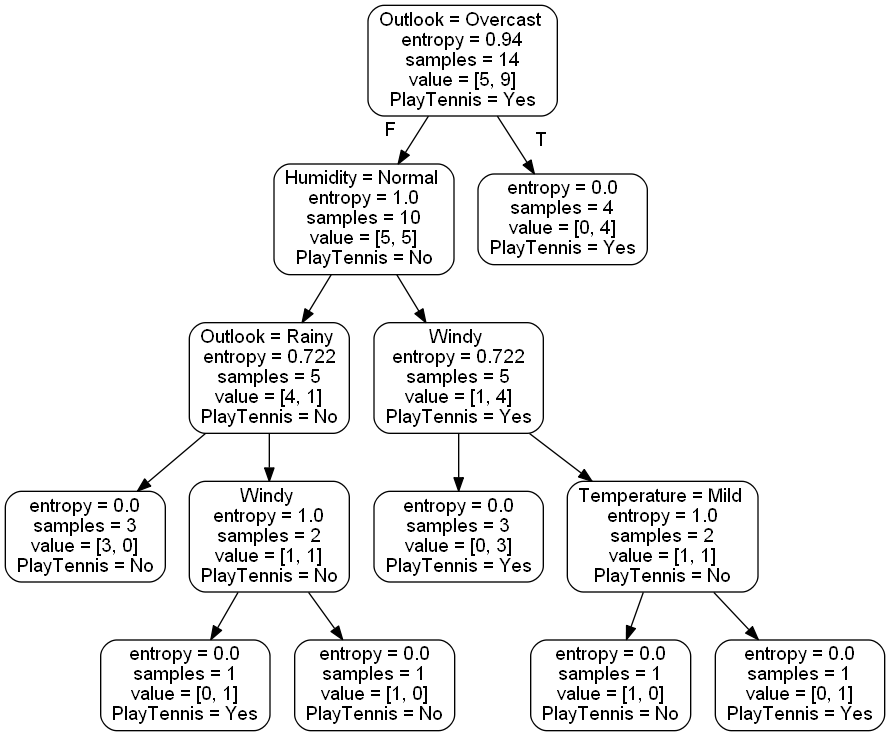

In [ ]:
dot_data = tree.export_graphviz(clf,
                                feature_names= X_train.columns,
                                class_names= le.classes_,
                                out_file=None,
                                filled=True,
                                rounded=True)

#Make the graph easier to interpret
dot_data = dot_data.replace("_"," = ")
dot_data = dot_data.replace("<= 0.5","")
dot_data = dot_data.replace("False","T")
dot_data = dot_data.replace("True","F")
dot_data = dot_data.replace("class",data.columns[-1])

graph = pydotplus.graph_from_dot_data(dot_data)

edges = collections.defaultdict(list)
        
for node in graph.get_node_list():
    if node.get_attributes().get('label') is None:
        continue
    if 'samples = ' in node.get_attributes()['label']:
        labels = node.get_attributes()['label'].split('<br/>')
        for i, label in enumerate(labels):
            if label.startswith('samples = '):
                labels[i] = 'samples = 0'
        node.set('label', '<br/>'.join(labels))
        node.set_fillcolor('white')     
        
filename = 'tennis_entropy.png'

graph.write_png(filename)

display(Image(filename=filename))


### **b. Simulation**

Now, let's simulate the decision tree classifying our data. We will use one sample the data from our training set.

,Windy,Outlook_Overcast,Outlook_Rainy,Outlook_Sunny,Temperature_Cool,Temperature_Hot,Temperature_Mild,Humidity_High,Humidity_Normal
5,True,0,1,0,1,0,0,0,1


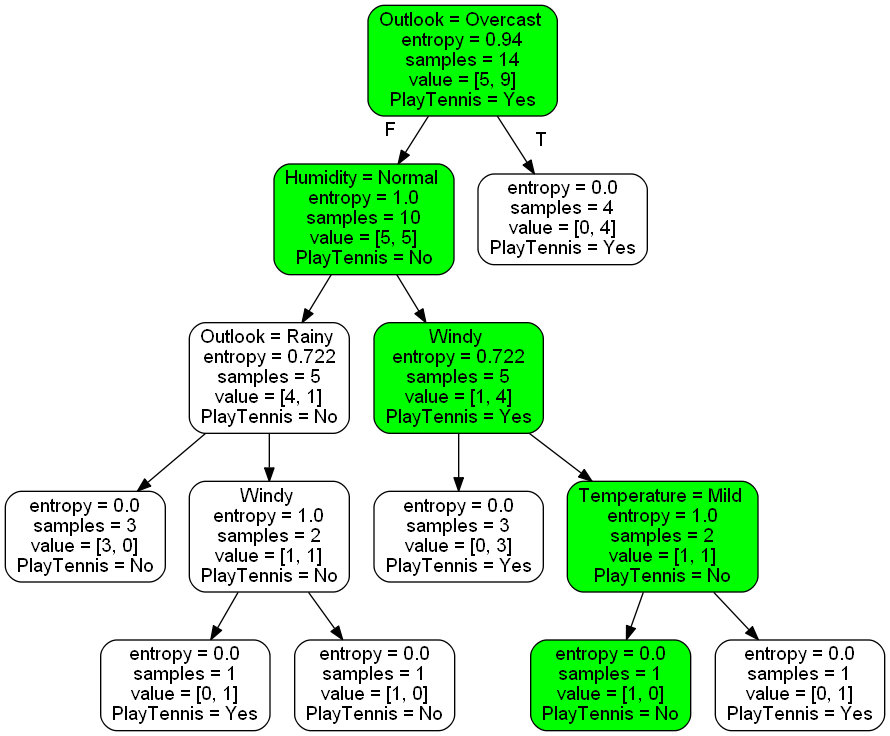

In [ ]:
samples = X_train.iloc[[5]]

display(samples)
decision_paths = clf.decision_path(samples)

#source: https://stackoverflow.com/questions/55878247/how-to-display-the-path-of-a-decision-tree-for-test-samples

#turn all nodes into white
for node in graph.get_node_list():
    if node.get_attributes().get('label') is None:
        continue
    if 'samples = ' in node.get_attributes()['label']:
        labels = node.get_attributes()['label'].split('<br/>')
        for i, label in enumerate(labels):
            if label.startswith('samples = '):
                labels[i] = 'samples = 0'
        node.set('label', '<br/>'.join(labels))
        node.set_fillcolor('white')

#colorized the visited node
for decision_path in decision_paths:
    for n, node_value in enumerate(decision_path.toarray()[0]):
        if node_value == 0:
            continue
        node = graph.get_node(str(n))[0]            
        node.set_fillcolor('green')
        labels = node.get_attributes()['label'].split('<br/>')
        for i, label in enumerate(labels):
            if label.startswith('samples = '):
                labels[i] = 'samples = {}'.format(int(label.split('=')[1]) + 1)

        node.set('label', '<br/>'.join(labels))

filename = 'tennis_entropy_simulation.png'        
graph.write_png(filename)
display(Image(filename=filename))


### **c. Evalutation**

In [ ]:
Train_predict = model.predict(X_train)

print ('Accuracy is:', accuracy_score(Y_train, Train_predict))
print (classification_report(Y_train, Train_predict, target_names = le.classes_))

Accuracy is: 1.0
              precision    recall  f1-score   support

          No       1.00      1.00      1.00         5
         Yes       1.00      1.00      1.00         9

    accuracy                           1.00        14
   macro avg       1.00      1.00      1.00        14
weighted avg       1.00      1.00      1.00        14



The accuracy for our training dataset is 100%. However, although it is perfect, it may overfit the training set. We should previously split the dataset into train and test. But, since the data is only 14, we can't do much with this dataset.

### ***Using Gini Index***

Now, we will try to build our decision tree using gini index. We will use scikit to create the tree. Pay attention that the tree we want to build is not using ID3 algorithm because scikit library only support CART algorithm (source: https://scikit-learn.org/stable/modules/tree.html#tree-algorithms-id3-c4-5-c5-0-and-cart)

In [ ]:
clf = tree.DecisionTreeClassifier(criterion = 'gini')
model = clf.fit(X_train,Y_train)

### **a. Visualizing the Tree**

Next, we visualize the tree by converting the model to DOT format (https://en.wikipedia.org/wiki/DOT_(graph_description_language). The DOT data then converted to an image.

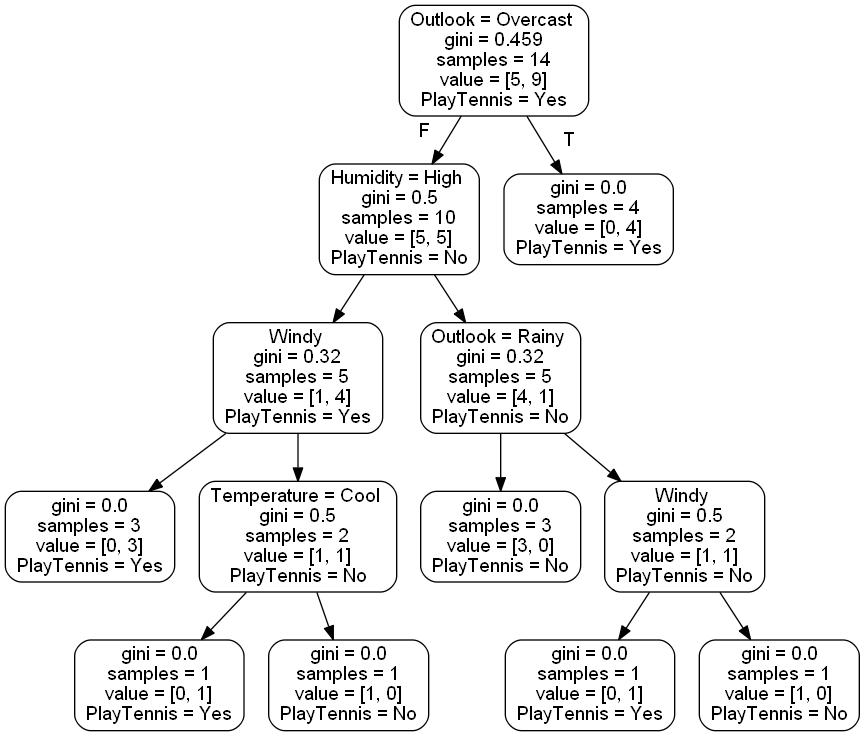

In [ ]:
dot_data = tree.export_graphviz(clf,
                                feature_names= X_train.columns,
                                class_names= le.classes_,
                                out_file=None,
                                filled=True,
                                rounded=True)

#Make the graph easier to interpret
dot_data = dot_data.replace("_"," = ")
dot_data = dot_data.replace("<= 0.5","")
dot_data = dot_data.replace("False","T")
dot_data = dot_data.replace("True","F")
dot_data = dot_data.replace("class",data.columns[-1])

graph = pydotplus.graph_from_dot_data(dot_data)

edges = collections.defaultdict(list)
        
for node in graph.get_node_list():
    if node.get_attributes().get('label') is None:
        continue
    if 'samples = ' in node.get_attributes()['label']:
        labels = node.get_attributes()['label'].split('<br/>')
        for i, label in enumerate(labels):
            if label.startswith('samples = '):
                labels[i] = 'samples = 0'
        node.set('label', '<br/>'.join(labels))
        node.set_fillcolor('white')     
        
filename = 'tennis_entropy.png'

graph.write_png(filename)

display(Image(filename=filename))


### **b. Simulation**

Now, let's simulate the decision tree classifying our data. We will use one sample the data from our training set.

,Windy,Outlook_Overcast,Outlook_Rainy,Outlook_Sunny,Temperature_Cool,Temperature_Hot,Temperature_Mild,Humidity_High,Humidity_Normal
5,True,0,1,0,1,0,0,0,1


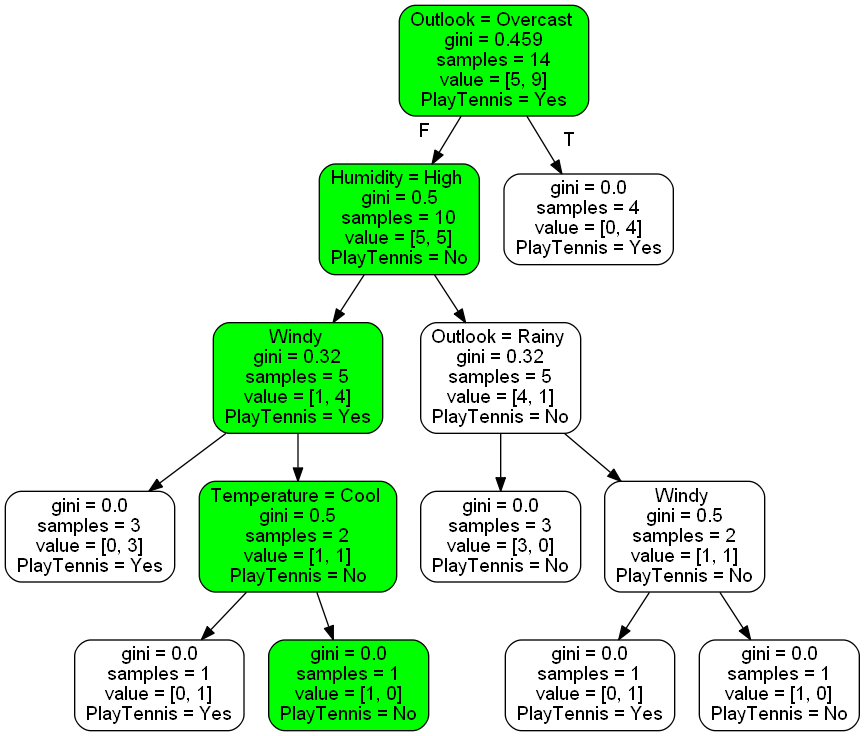

In [ ]:
samples = X_train.iloc[[5]]

display(samples)
decision_paths = clf.decision_path(samples)

#source: https://stackoverflow.com/questions/55878247/how-to-display-the-path-of-a-decision-tree-for-test-samples

#turn all nodes into white
for node in graph.get_node_list():
    if node.get_attributes().get('label') is None:
        continue
    if 'samples = ' in node.get_attributes()['label']:
        labels = node.get_attributes()['label'].split('<br/>')
        for i, label in enumerate(labels):
            if label.startswith('samples = '):
                labels[i] = 'samples = 0'
        node.set('label', '<br/>'.join(labels))
        node.set_fillcolor('white')

#colorized the visited node
for decision_path in decision_paths:
    for n, node_value in enumerate(decision_path.toarray()[0]):
        if node_value == 0:
            continue
        node = graph.get_node(str(n))[0]            
        node.set_fillcolor('green')
        labels = node.get_attributes()['label'].split('<br/>')
        for i, label in enumerate(labels):
            if label.startswith('samples = '):
                labels[i] = 'samples = {}'.format(int(label.split('=')[1]) + 1)

        node.set('label', '<br/>'.join(labels))

filename = 'tennis_gini_simulation.png'        
graph.write_png(filename)
display(Image(filename=filename))


### **c. Evalutation**

In [ ]:
Train_predict = model.predict(X_train)

print ('Accuracy is:', accuracy_score(Y_train, Train_predict))
print (classification_report(Y_train, Train_predict, target_names = le.classes_))

Accuracy is: 1.0
              precision    recall  f1-score   support

          No       1.00      1.00      1.00         5
         Yes       1.00      1.00      1.00         9

    accuracy                           1.00        14
   macro avg       1.00      1.00      1.00        14
weighted avg       1.00      1.00      1.00        14



The accuracy for our training dataset is 100%, same as using the entropy. However, although it is perfect, it may overfit the training set. We should previously split the dataset into train and test. But, since the data is only 14, we can't do much with this dataset.

# ***Credit Risk Dataset***

## **1.Import & Analyse Dataset**

In [ ]:
data = pd.read_csv('credithistory.csv')

display(data)

,risk,collateral,income,debt,credithistory
0,high,none,$0to$15K,high,bad
1,high,none,$15Kto$35K,high,unknown
2,moderate,none,$15Kto$35K,low,unknown
3,high,none,$0to$15K,low,unknown
4,low,none,over$35K,low,unknown
5,low,adequate,over$35K,low,unknown
6,high,none,$0to$15K,low,bad
7,moderate,adequate,over$35K,low,bad
8,low,none,over$35K,low,good
9,low,adequate,over$35K,high,good


Our goal is to predict the risk (high,moderate, or low) based on  4 features: collateral, income, debt, and credithistory. All the features are categorical, so we don't need to do any split on continuous feature. You might think that the income is numerical, but actually it has been previously categorized by specific range of income.

## **2.Preprocessing**

Because we are dealing with categorical data, we need to encode it first. There are many ways to encode categorical data, in this case we will use pandas get_dummies function, which will automatically detect and one-hot encode categorical data based on the object type. But, for the target value, we don't want to hot encode it, so we will use LabelEncoder.

In [ ]:
X_train = pd.get_dummies(data.iloc[:, 1:], prefix_sep='_', drop_first = False, sparse=True)
display(X_train)

le = LabelEncoder()
Y_train = le.fit_transform(data.iloc[:, :1].values.tolist())
Y_train = pd.DataFrame(Y_train, columns = [data.columns[0]])
display(Y_train)

,collateral_adequate,collateral_none,income_$0to$15K,income_$15Kto$35K,income_over$35K,debt_high,debt_low,credithistory_bad,credithistory_good,credithistory_unknown
0,0,1,1,0,0,1,0,1,0,0
1,0,1,0,1,0,1,0,0,0,1
2,0,1,0,1,0,0,1,0,0,1
3,0,1,1,0,0,0,1,0,0,1
4,0,1,0,0,1,0,1,0,0,1
5,1,0,0,0,1,0,1,0,0,1
6,0,1,1,0,0,0,1,1,0,0
7,1,0,0,0,1,0,1,1,0,0
8,0,1,0,0,1,0,1,0,1,0
9,1,0,0,0,1,1,0,0,1,0


D:\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,risk
0,0
1,0
2,2
3,0
4,1
5,1
6,0
7,2
8,1
9,1


## **3.Creating The Decision Tree**

### ***Using Entropy***

First, we will try to build our decision tree using entropy as information gain. We will use scikit to create the tree. Pay attention that the tree we want to build is not using ID3 algorithm because scikit library only support CART algorithm (source: https://scikit-learn.org/stable/modules/tree.html#tree-algorithms-id3-c4-5-c5-0-and-cart)

In [ ]:
clf = tree.DecisionTreeClassifier(criterion = 'entropy')
model = clf.fit(X_train,Y_train)

### **a. Visualizing the Tree**

Next, we visualize the tree by converting the model to DOT format (https://en.wikipedia.org/wiki/DOT_(graph_description_language). The DOT data then converted to an image.

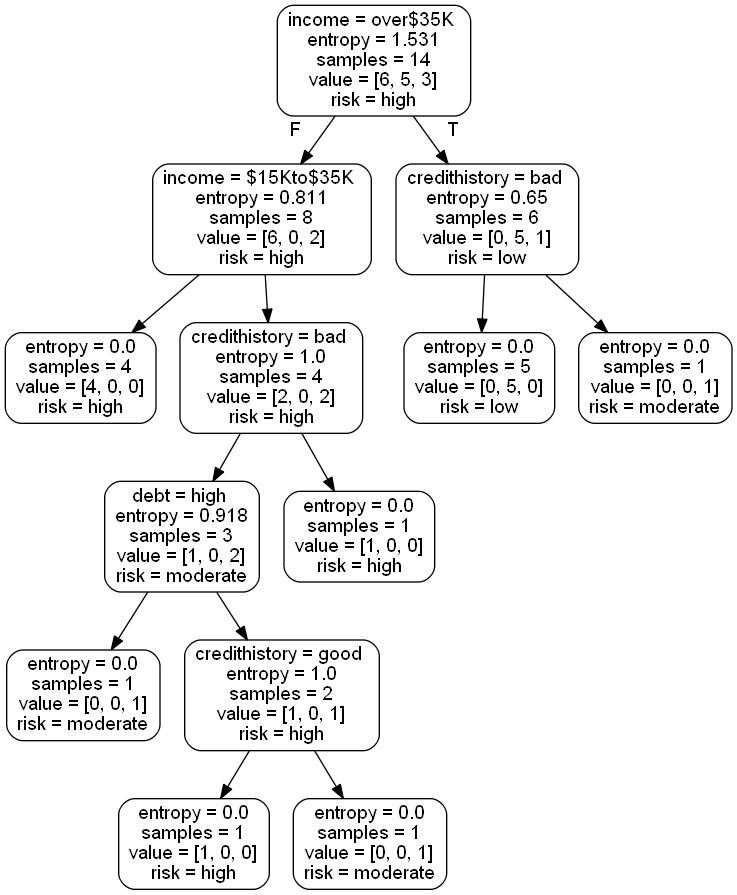

In [ ]:
dot_data = tree.export_graphviz(clf,
                                feature_names= X_train.columns,
                                class_names= le.classes_,
                                out_file=None,
                                filled=True,
                                rounded=True)

#Make the graph easier to interpret
dot_data = dot_data.replace("_"," = ")
dot_data = dot_data.replace("<= 0.5","")
dot_data = dot_data.replace("False","T")
dot_data = dot_data.replace("True","F")
dot_data = dot_data.replace("class",data.columns[0])

graph = pydotplus.graph_from_dot_data(dot_data)

edges = collections.defaultdict(list)
        
for node in graph.get_node_list():
    if node.get_attributes().get('label') is None:
        continue
    if 'samples = ' in node.get_attributes()['label']:
        labels = node.get_attributes()['label'].split('<br/>')
        for i, label in enumerate(labels):
            if label.startswith('samples = '):
                labels[i] = 'samples = 0'
        node.set('label', '<br/>'.join(labels))
        node.set_fillcolor('white')     
        
filename = 'tennis_entropy.png'

graph.write_png(filename)

display(Image(filename=filename))


### **b. Simulation**

Now, let's simulate the decision tree classifying our data. We will use one sample the data from our training set.

,collateral_adequate,collateral_none,income_$0to$15K,income_$15Kto$35K,income_over$35K,debt_high,debt_low,credithistory_bad,credithistory_good,credithistory_unknown
1,0,1,0,1,0,1,0,0,0,1


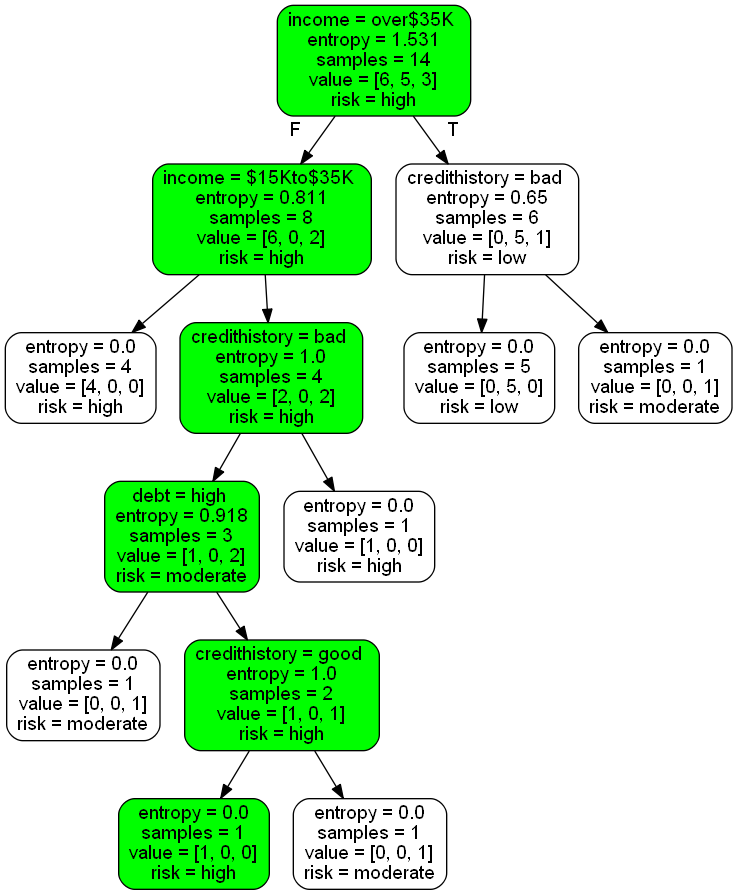

In [ ]:
samples = X_train.iloc[[1]]

display(samples)
decision_paths = clf.decision_path(samples)

#source: https://stackoverflow.com/questions/55878247/how-to-display-the-path-of-a-decision-tree-for-test-samples

#turn all nodes into white
for node in graph.get_node_list():
    if node.get_attributes().get('label') is None:
        continue
    if 'samples = ' in node.get_attributes()['label']:
        labels = node.get_attributes()['label'].split('<br/>')
        for i, label in enumerate(labels):
            if label.startswith('samples = '):
                labels[i] = 'samples = 0'
        node.set('label', '<br/>'.join(labels))
        node.set_fillcolor('white')

#colorized the visited node
for decision_path in decision_paths:
    for n, node_value in enumerate(decision_path.toarray()[0]):
        if node_value == 0:
            continue
        node = graph.get_node(str(n))[0]            
        node.set_fillcolor('green')
        labels = node.get_attributes()['label'].split('<br/>')
        for i, label in enumerate(labels):
            if label.startswith('samples = '):
                labels[i] = 'samples = {}'.format(int(label.split('=')[1]) + 1)

        node.set('label', '<br/>'.join(labels))

filename = 'credit_entropy_simulation.png'        
graph.write_png(filename)
display(Image(filename=filename))


### **c. Evalutation**

In [ ]:
Train_predict = model.predict(X_train)

print ('Accuracy is:', accuracy_score(Y_train, Train_predict))
print (classification_report(Y_train, Train_predict,target_names= le.classes_))

Accuracy is: 1.0
              precision    recall  f1-score   support

        high       1.00      1.00      1.00         6
         low       1.00      1.00      1.00         5
    moderate       1.00      1.00      1.00         3

    accuracy                           1.00        14
   macro avg       1.00      1.00      1.00        14
weighted avg       1.00      1.00      1.00        14



The accuracy for our training dataset is 100%. However, although it is perfect, it may overfit the training set. We should previously split the dataset into train and test. But, since the data is only 14, we can't do much with this dataset.

### ***Using Gini Index***

Now, we will try to build our decision tree using gini index. We will use scikit to create the tree. Pay attention that the tree we want to build is not using ID3 algorithm because scikit library only support CART algorithm (source: https://scikit-learn.org/stable/modules/tree.html#tree-algorithms-id3-c4-5-c5-0-and-cart)

In [ ]:
clf = tree.DecisionTreeClassifier(criterion = 'gini')
model = clf.fit(X_train,Y_train)

### **a. Visualizing the Tree**

Next, we visualize the tree by converting the model to DOT format (https://en.wikipedia.org/wiki/DOT_(graph_description_language). The DOT data then converted to an image.

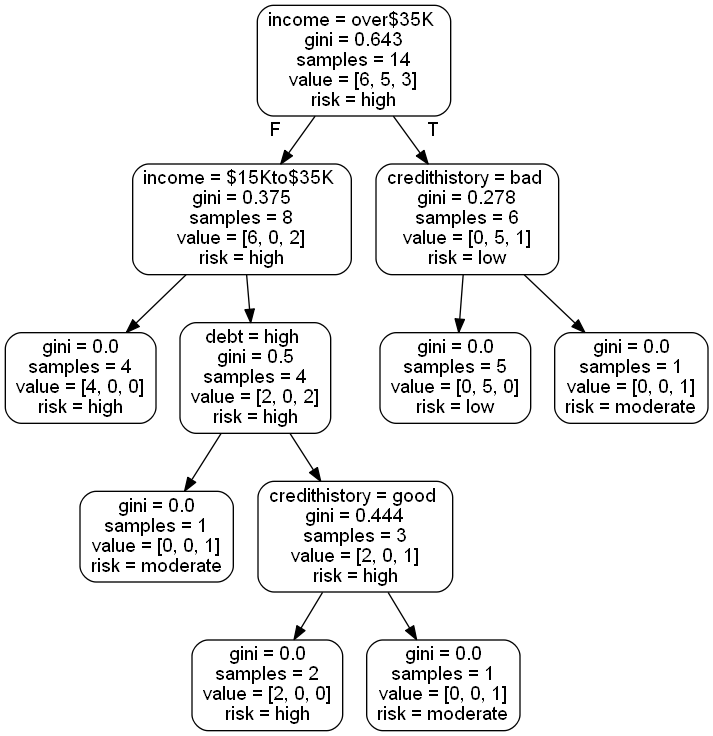

In [ ]:
dot_data = tree.export_graphviz(clf,
                                feature_names= X_train.columns,
                                class_names= le.classes_,
                                out_file=None,
                                filled=True,
                                rounded=True)

#Make the graph easier to interpret
dot_data = dot_data.replace("_"," = ")
dot_data = dot_data.replace("<= 0.5","")
dot_data = dot_data.replace("False","T")
dot_data = dot_data.replace("True","F")
dot_data = dot_data.replace("class",data.columns[0])

graph = pydotplus.graph_from_dot_data(dot_data)

edges = collections.defaultdict(list)
        
for node in graph.get_node_list():
    if node.get_attributes().get('label') is None:
        continue
    if 'samples = ' in node.get_attributes()['label']:
        labels = node.get_attributes()['label'].split('<br/>')
        for i, label in enumerate(labels):
            if label.startswith('samples = '):
                labels[i] = 'samples = 0'
        node.set('label', '<br/>'.join(labels))
        node.set_fillcolor('white')     
        
filename = 'credit_gini.png'

graph.write_png(filename)

display(Image(filename=filename))


### **b. Simulation**

Now, let's simulate the decision tree classifying our data. We will use one sample the data from our training set.

,collateral_adequate,collateral_none,income_$0to$15K,income_$15Kto$35K,income_over$35K,debt_high,debt_low,credithistory_bad,credithistory_good,credithistory_unknown
1,0,1,0,1,0,1,0,0,0,1


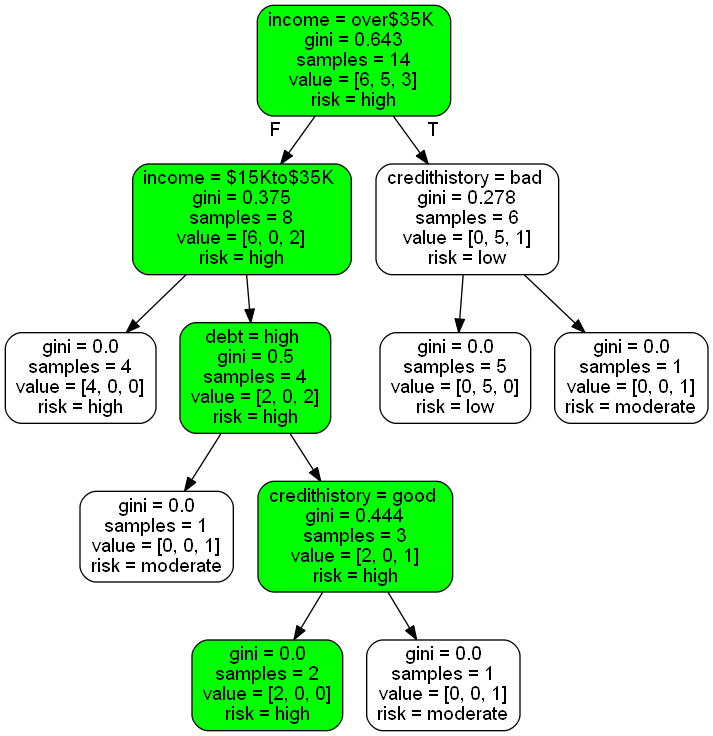

In [ ]:
samples = X_train.iloc[[1]]

display(samples)
decision_paths = clf.decision_path(samples)

#source: https://stackoverflow.com/questions/55878247/how-to-display-the-path-of-a-decision-tree-for-test-samples

#turn all nodes into white
for node in graph.get_node_list():
    if node.get_attributes().get('label') is None:
        continue
    if 'samples = ' in node.get_attributes()['label']:
        labels = node.get_attributes()['label'].split('<br/>')
        for i, label in enumerate(labels):
            if label.startswith('samples = '):
                labels[i] = 'samples = 0'
        node.set('label', '<br/>'.join(labels))
        node.set_fillcolor('white')

#colorized the visited node
for decision_path in decision_paths:
    for n, node_value in enumerate(decision_path.toarray()[0]):
        if node_value == 0:
            continue
        node = graph.get_node(str(n))[0]            
        node.set_fillcolor('green')
        labels = node.get_attributes()['label'].split('<br/>')
        for i, label in enumerate(labels):
            if label.startswith('samples = '):
                labels[i] = 'samples = {}'.format(int(label.split('=')[1]) + 1)

        node.set('label', '<br/>'.join(labels))

filename = 'credit_gini_simulation.png'        
graph.write_png(filename)
display(Image(filename=filename))


### **c. Evalutation**

In [ ]:
Train_predict = model.predict(X_train)

print ('Accuracy is:', accuracy_score(Y_train, Train_predict))
print (classification_report(Y_train, Train_predict,target_names= le.classes_))

Accuracy is: 1.0
              precision    recall  f1-score   support

        high       1.00      1.00      1.00         6
         low       1.00      1.00      1.00         5
    moderate       1.00      1.00      1.00         3

    accuracy                           1.00        14
   macro avg       1.00      1.00      1.00        14
weighted avg       1.00      1.00      1.00        14



The accuracy for our training dataset is 100%, same as using the entropy. However, although it is perfect, it may overfit the training set. We should previously split the dataset into train and test. But, since the data is only 14, we can't do much with this dataset.